This notebook implements the solution using PyTorch instead of TensorFlow/Keras.

In [3]:
%pip install matplotlib scikit-learn "opencv-python>4" imutils torch torchvision

In [4]:
import os, pickle, glob, math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from lab_2_helpers import *

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Preprocessing


In [5]:
!tar -xJf captcha-images.tar.xz

In [6]:
# Dataset images folder
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
# Review image paths
pprint(captcha_image_paths[:10])

['./captcha-images/8ADH.png',
 './captcha-images/N2FD.png',
 './captcha-images/J2FP.png',
 './captcha-images/C4F7.png',
 './captcha-images/6TSC.png',
 './captcha-images/3CW7.png',
 './captcha-images/L6SE.png',
 './captcha-images/8CLH.png',
 './captcha-images/J7SF.png',
 './captcha-images/4FS8.png']


In [7]:
def extract_captcha_text(image_path):
    """ Extract correct CAPTCHA texts from file name of images. """
    # Extract file name of image from its path
    # e.g. "./captcha-images/2A2X.png" -> "2A2X.png"
    image_file_name = os.path.basename(image_path)
    # Extract base name of image, omitting file extension
    # e.g. "2A2X.png" -> "2A2X"
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
# Review extraction results
pprint(captcha_texts[:10])

['8ADH', 'N2FD', 'J2FP', 'C4F7', '6TSC', '3CW7', 'L6SE', '8CLH', 'J7SF', '4FS8']


## Loading and Transforming Images



Figure(2000x500)


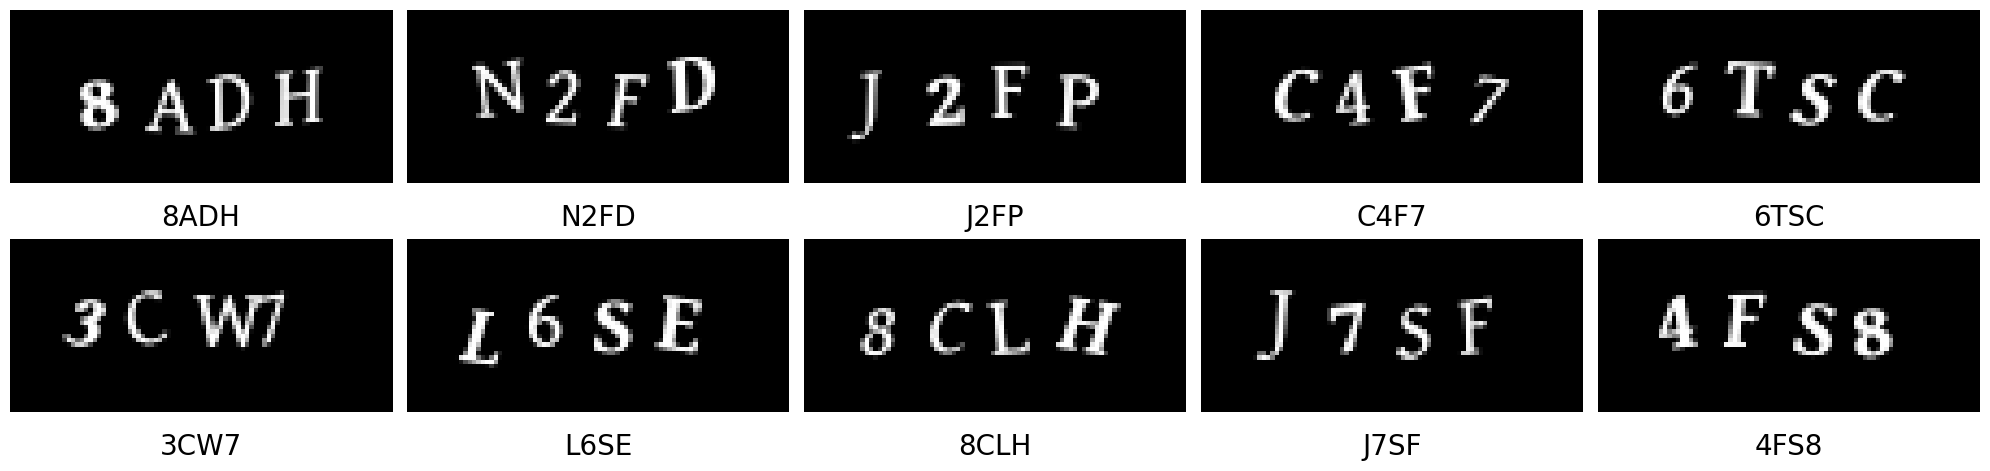

In [8]:
def load_transform_image(image_path):
    """ Load and transform image into grayscale. """
    # 1) Load image with OpenCV
    image = cv2.imread(image_path)

    # 2) Convert image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 3) Add extra padding (8px) around the image
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]
# Review loaded CAPTCHAs
print_images(
    captcha_images[:10], n_rows=2, texts=captcha_texts[:10]
)

In [9]:
# Train-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Perform split on CAPTCHA images as well as labels
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


## Bounding Box Extraction
It's now time to perform the most important feature extraction step: finding contours and extracting characters. Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. It is useful for shape analysis and object detection and recognition. For our task however, we are **more interested in the bounding boxes around characters**, since these are the part of images we will be used for character classification.

Here are the steps we are going to perform:

* Find contours around characters in CAPTCHAs.
* Get the position and size for each corresponding bounding box.
* If a bounding box is too wide (width-to-height ratio larger than 1.25), chances are that we have bounded two letters in a single bounding box. In this case, split the bounding box vertically from the center into two.
* Store all bounding boxes for the CAPTCHA.
* If there aren't 4 bounding boxes for the CAPTCHA, ignore it since our character extraction process must have run into problems in this case.
* Sort the bounding boxes by their X coordinates, so that they match the order corresponding letters occur.
* For each bounding box, extract corresponding region of the image, and store it as an instance of corresponding character at `${CHAR_IMAGE_FOLDER}/{letter}/{count}.png`.

After these steps, we have transformed CAPTCHA images into images of single character. This simplifies our task since now our model only needs to deal with classification (from character image to character itself) rather than also dealing with detection (finding and extracting charatcers).

In [10]:
# Character images folder template
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    """ Find contours and extract characters inside each CAPTCHA. """
    # Threshold image and convert it to black-white
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Find contours (continuous blobs of pixels) the image
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    # Loop through each contour
    for contour in contours:
        # Get the rectangle that contains the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Compare the width and height of the bounding box,
        # detect if there are letters conjoined into one chunk
        if w / h > 1.25:
            # Bounding box is too wide for a single character
            # Split it in half into two letter regions
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            # Only a single letter in contour
            char_regions.append((x, y, w, h))

    # Ignore image if less or more than 4 regions detected
    if len(char_regions)!=4:
        return None
    # Sort regions by their X coordinates
    char_regions.sort(key=lambda x: x[0])

    # Character images
    char_images = []
    # Save each character as a single image
    for x, y, w, h in char_regions:
        # Extract character from image with 2px margin
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        # Save character images
        char_images.append(char_image)

    # Return character images
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """ Save character images to directory. """
    for char_image, char in zip(char_images, captcha_text):
        # Get the folder to save the image in
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)

        # Write letter image to file
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)

        # Update count
        char_counts[char] = char_count+1

# Force character extraction even if results are already available
FORCE_EXTRACT_CHAR = False

char_counts = {}
# Extract and save images for characters
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        # Extract character images
        char_images = extract_chars(captcha_image)
        # Skip if extraction failed
        if char_images is None:
            continue
        # Save character images
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

## Label Encoding


In [11]:
# Path of occurred characters (labels)
LABELS_PATH = "./labels.pkl"

def make_feature(image):
    """ Process character image and turn it into feature. """
    # Resize letter to 20*20
    image_resized = resize_to_fit(image, 20, 20)
    # Add extra dimension as the only channel
    feature = image_resized[..., None]

    return feature

def make_feature_label(image_path):
    """ Load character image and make feature-label pair from image path. """
    # Load image and make feature
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    # Extract label based on the directory the image is in
    label = image_path.split(os.path.sep)[-2]

    return feature, label

# Make features and labels from character image paths
features_tv, labels_tv = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))

# Scale raw pixel values into range [0, 1]
features_tv = np.array(features_tv, dtype="float")/255
# Convert labels into one-hot encodings
lb = LabelBinarizer()
labels_one_hot_tv = lb.fit_transform(labels_tv)
# Number of classes
n_classes = len(lb.classes_)

# Further split the training data into training and validation set
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_one_hot_tv, test_size=0.25, random_state=955996
)
# Save mapping from labels to one-hot encoding
with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

# Training


In [12]:
# PyTorch Dataset class for character images
class CharacterDataset(Dataset):
    def __init__(self, features, labels):
        # PyTorch expects (N, C, H, W) format, so we need to permute from (N, H, W, C)
        self.features = torch.FloatTensor(features).permute(0, 3, 1, 2)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = CharacterDataset(X_train, y_train)
vali_dataset = CharacterDataset(X_vali, y_vali)

# Batch size
BATCH_SIZE = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Define the CNN model in PyTorch
class CaptchaCNN(nn.Module):
    def __init__(self, n_classes):
        super(CaptchaCNN, self).__init__()

        # First convolution block: (*, 1, 20, 20) -Conv2D+ReLU-> (*, 20, 20, 20) -MaxPooling2D-> (*, 20, 10, 10)
        # Conv layer: 20 channels, 5x5 kernel, padding='same' to maintain shape
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolution block: (*, 20, 10, 10) -Conv2D+ReLU-> (*, 50, 10, 10) -MaxPooling2D-> (*, 50, 5, 5)
        # Conv layer: 50 channels, 5x5 kernel, padding='same'
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten layer: (*, 50, 5, 5) -> (*, 1250)
        self.flatten = nn.Flatten()

        # First fully-connected layer: (*, 1250) -FC+ReLU-> (*, 500)
        self.fc1 = nn.Linear(50 * 5 * 5, 500)
        self.relu3 = nn.ReLU()

        # Last fully-connected layer: (*, 500) -FC-> (*, n_classes)
        # NOTE: We don't include softmax here because CrossEntropyLoss includes it
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x, apply_softmax=False):
        # First conv block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        # Only apply softmax for inference, not training
        if apply_softmax:
            x = torch.softmax(x, dim=1)

        return x

# Create model instance
model = CaptchaCNN(n_classes).to(device)

# Display model architecture
print(model)

CaptchaCNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=32, bias=True)
)


In [14]:
# Number of epochs
N_EPOCHS = 10

# Path of model weights file
MODEL_WEIGHTS_PATH = "./captcha-model-pytorch.pth"
# Force training even if weights are already available
FORCE_TRAINING = True

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Works with softmax output
optimizer = optim.Adam(model.parameters())

def train_epoch(model, train_loader, criterion, optimizer, device):
    """ Train the model for one epoch. """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)

        # Calculate loss (convert one-hot to class indices)
        labels_indices = torch.argmax(labels, dim=1)
        loss = criterion(outputs, labels_indices)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels_indices).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, vali_loader, criterion, device):
    """ Validate the model. """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in vali_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)

            # Calculate loss
            labels_indices = torch.argmax(labels, dim=1)
            loss = criterion(outputs, labels_indices)

            # Statistics
            running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels_indices).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    # Train the neural network model
    print("Training the model...")
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        vali_loss, vali_acc = validate(model, vali_loader, criterion, device)

        print(f"Epoch {epoch+1}/{N_EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {vali_loss:.4f}, Val Acc: {vali_acc:.4f}")

    # Save model weights to disk
    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    print(f"\nModel saved to {MODEL_WEIGHTS_PATH}")
else:
    # Load pre-trained weights
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device))
    print(f"Model loaded from {MODEL_WEIGHTS_PATH}")

Training the model...
Epoch 1/10
  Train Loss: 2.0957, Train Acc: 0.4666
  Val Loss: 0.3799, Val Acc: 0.9205
Epoch 2/10
  Train Loss: 0.1853, Train Acc: 0.9601
  Val Loss: 0.1160, Val Acc: 0.9866
Epoch 3/10
  Train Loss: 0.0689, Train Acc: 0.9873
  Val Loss: 0.0817, Val Acc: 0.9877
Epoch 4/10
  Train Loss: 0.0311, Train Acc: 0.9940
  Val Loss: 0.0857, Val Acc: 0.9821
Epoch 5/10
  Train Loss: 0.0240, Train Acc: 0.9937
  Val Loss: 0.0808, Val Acc: 0.9877
Epoch 6/10
  Train Loss: 0.0093, Train Acc: 0.9993
  Val Loss: 0.0751, Val Acc: 0.9899
Epoch 7/10
  Train Loss: 0.0070, Train Acc: 0.9993
  Val Loss: 0.0798, Val Acc: 0.9888
Epoch 8/10
  Train Loss: 0.0015, Train Acc: 1.0000
  Val Loss: 0.0746, Val Acc: 0.9899
Epoch 9/10
  Train Loss: 0.0007, Train Acc: 1.0000
  Val Loss: 0.0772, Val Acc: 0.9899
Epoch 10/10
  Train Loss: 0.0005, Train Acc: 1.0000
  Val Loss: 0.0805, Val Acc: 0.9899

Model saved to ./captcha-model-pytorch.pth


# Evaluation


In [15]:
# Load labels from file (so we can translate model predictions to actual letters)
with open(LABELS_PATH, "rb") as f:
    lb = pickle.load(f)

# Test our pipeline (and model) with the test set.
# However, you'd want to replace this with some random CAPTCHAs in the real world.

# Dummy character images
DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1))

# Indices of CAPTCHAs on which extractions failed
extract_failed_indices = []
# Extracted character images
char_images_test = []

# Extract character images and make features
for i, captcha_image in enumerate(captcha_images_test):
    # Extract character images
    char_images = extract_chars(captcha_image)

    if char_images:
        char_images_test.extend(char_images)
    # Use dummy character images as placeholder if extraction failed
    else:
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

# Make features for character images
features_test = [make_feature(char_image) for char_image in char_images_test]
# Scale raw pixel values into range [0, 1]
features_test = np.array(features_test, dtype="float")/255

# Convert to PyTorch tensor and permute to (N, C, H, W)
features_test_tensor = torch.FloatTensor(features_test).permute(0, 3, 1, 2).to(device)

# Predict labels with neural network
model.eval()
with torch.no_grad():
    preds_test = model(features_test_tensor, apply_softmax=True)
    preds_test = preds_test.cpu().numpy()

# Convert one-hot encoded characters back
preds_test = lb.inverse_transform(preds_test)

# Group all 4 characters for the same CAPTCHA
preds_test = ["".join(chars) for chars in group_every(preds_test, 4)]
# Update result for CAPTCHAs on which extractions failed
for i in extract_failed_indices:
    preds_test[i] = "-"

# of test CAPTCHAs: 228
# correctly recognized: 218
Accuracy: 0.956140350877193 

Figure(2000x500)
Figure(2000x600)


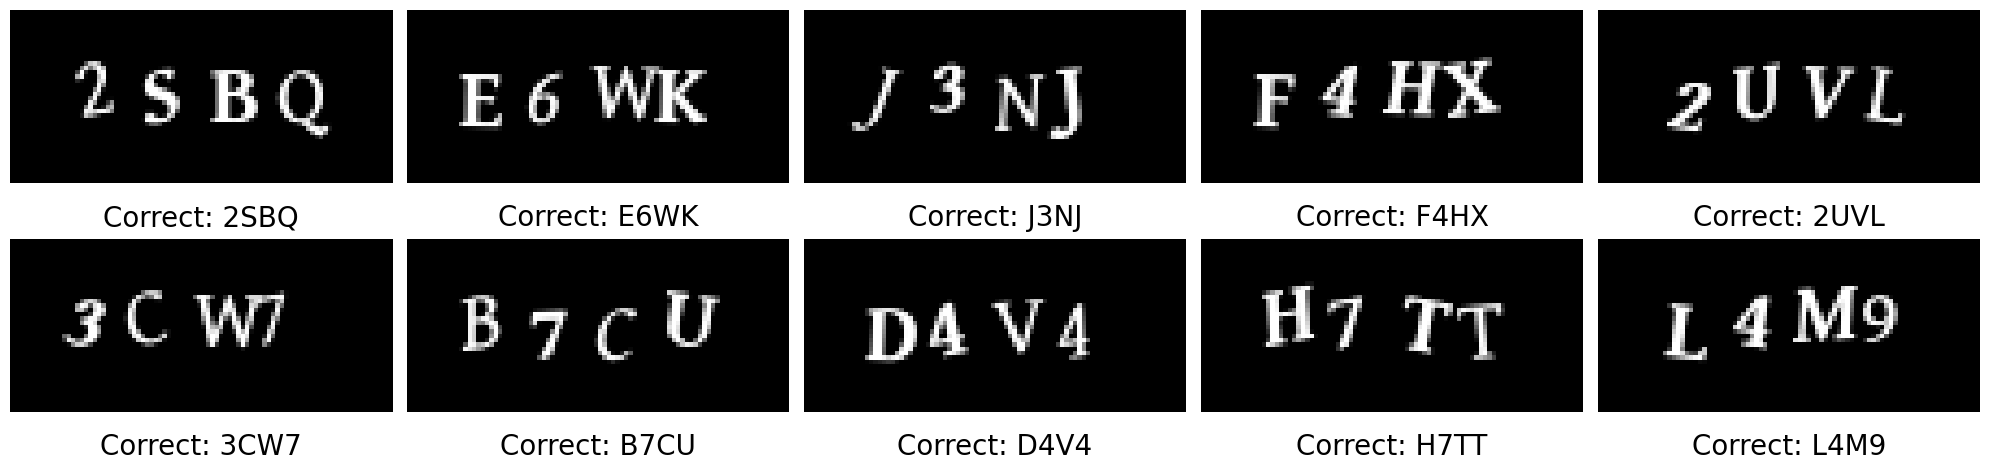

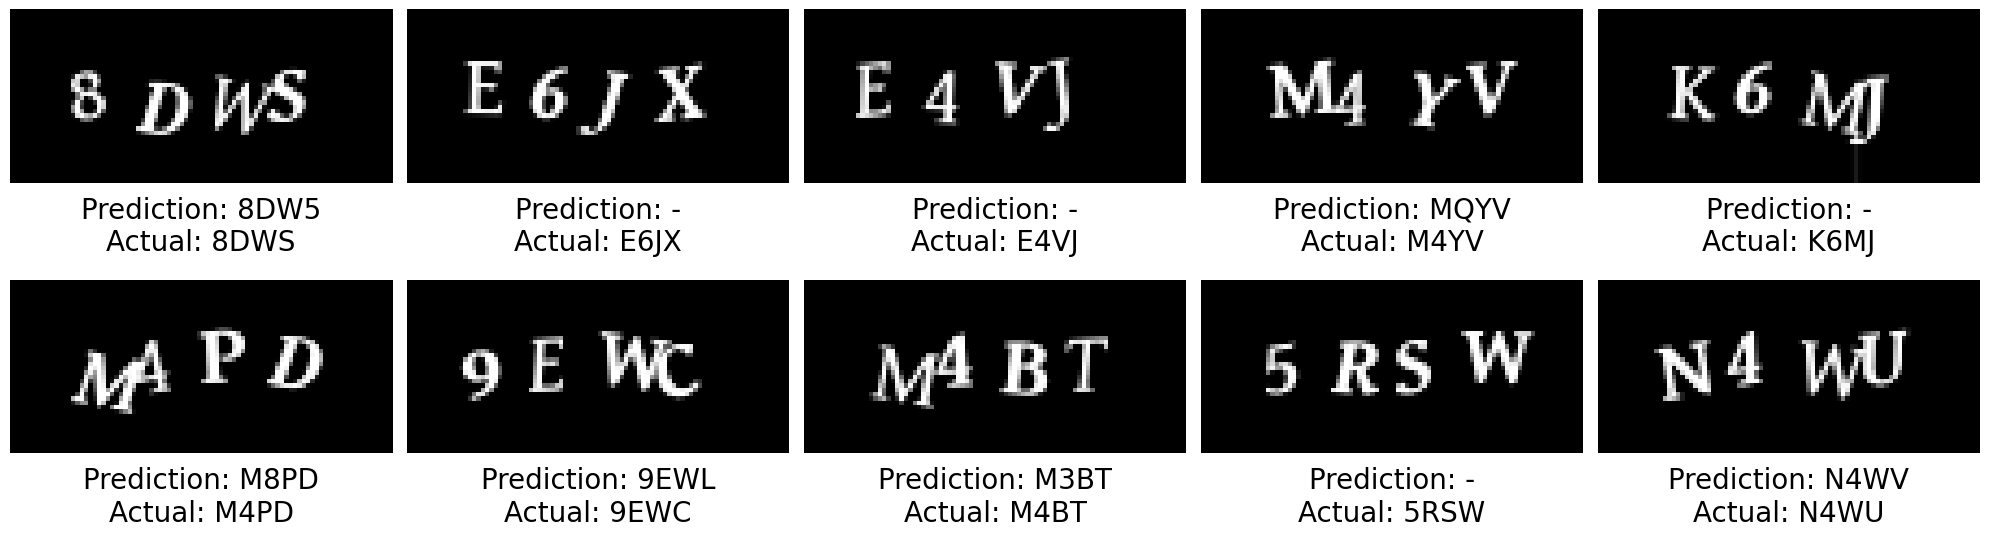

In [16]:
# Number of CAPTCHAs to display
N_DISPLAY_SAMPLES = 10

# Number of test CAPTCHAs
n_test = len(captcha_texts_test)
# Number of correct predictions
n_correct = 0

# Indices of correct predictions
correct_indices = []
# Indices of incorrect predictions
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text==actual_text:
        # 1) Update number of correct predictions
        n_correct += 1
        # 2) Collect index of correct prediction
        if len(correct_indices)<N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        # 3) Collect index of incorrect prediction
        if len(incorrect_indices)<N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

# Show number of total / correct predictions and accuracy
print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", n_correct/n_test, "\n")

# Show all correct predictions
print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

# Show all incorrect predictions
print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[
        f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}" \
        for i in incorrect_indices
    ],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)